# Neural Collaborative Filtering

Collaborative filtering is traditionally done with matrix factorization. I did my movie recommendation project using good ol' matrix factorization. However, recently I discovered that people have proposed new ways to do collaborative filtering with deep learning techniques! There's a paper, titled [Neural Collaborative Filtering](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf), from 2017 which describes the approach to perform collaborative filtering using neural networks.

> In recent years, deep neural networks have yielded immense success on speech recognition, computer vision and 
> natural language processing. However, the exploration of deep neural networks on recommender systems has received 
> relatively less scrutiny. In this work, we strive to develop techniques based on neural networks to tackle the
> key problem in recommendation — collaborative filtering — on the basis of implicit feedback.

Here's the high level idea.

![ncf-high-level](./neural_collaborative_filtering_files/ncf-high-level.png)

We perform embedding for each user and item(movie). The embedding layer(s) is simply a matrix dot product of one hot encoding of a user/movie and the embedding weights.

In [1]:
from keras.utils.np_utils import to_categorical

# We have 10 users, each is uniquely identified by an ID.
users = [i for i in range(10)]

one_hot_encoding_users = to_categorical(users)
print one_hot_encoding_users

Using TensorFlow backend.


[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


The embedding vectors will be fed into a deep neural network and its objective is to predict the rating from a user to a movie. For example, user 1 may rate movie 1 with five stars. The network should be able to predict that after training.

## Movie Ratings

Before we dive into the details of the architecture, let's take a look at the datasets that we will be using for this exercise. I got the data from MovieLens. I will use the small dataset with 100,000 movie ratings.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('../datasets/100k/ratings.csv', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Need to map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1 
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print 'Number of movies', num_movies
print 'Number of users', num_users

Number of movies 9067
Number of users 671


In [19]:
train.head()

,user_id,movie_id,rating,timestamp
58942,427,3163,3.5,1115178387
44821,313,5515,4.0,1101034397
65803,468,736,3.0,1296193334
80659,547,8213,4.0,1380982611
35624,255,413,5.0,1237062201


In [20]:
test.head()

,user_id,movie_id,rating,timestamp
39372,287,1009,4.0,1469754337
2053,15,1379,3.5,1347936794
90508,599,3466,4.0,1344133761
87827,585,1947,4.0,974607610
19754,131,282,3.0,992139118


## Generalized Matrix Factorization (GMF)

In the context of the paper, a generalized matrix factorization can be described by the following equation.

$$
\hat{y}_{ui} = a\left(h^{T}(p_{u} \cdot q_{i})\right)
$$

where $a$ is an activation function and $h$ is the edge weight matrix of the output layer. The edge weight matrix can be seen as an additional weight to the layer. 

If we use an identity function for activation and enforce the edge weight matrix to be a uniform vector of 1, we can exactly recover the standard matrix factorization model. However, we will do something more here to make it non-linear.

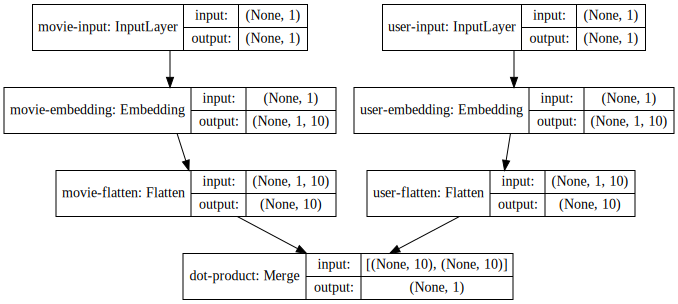

In [21]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge
from keras.utils.visualize_util import model_to_dot
from IPython.display import SVG

latent_dim = 10

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = merge([movie_vec, user_vec], mode='dot',name='dot-product')

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In the model above, we are not using any activation function and there is no additional weight to layer. The model above represents a classic matrix factorization. It takes two inputs, a user ID and a movie ID. The inputs are embedded into `(1, 10)` vectors. The vectors are then flattened. The dot product of the flattened vectors is the predicted rating.

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
movie-input (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
user-input (InputLayer)          (None, 1)             0                                            
____________________________________________________________________________________________________
movie-embedding (Embedding)      (None, 1, 10)         90670       movie-input[0][0]                
____________________________________________________________________________________________________
user-embedding (Embedding)       (None, 1, 10)         6720        user-input[0][0]                 
___________________________________________________________________________________________

In [38]:
history = model.fit([train.user_id, train.movie_id], train.rating, nb_epoch=100)

Epoch 1/100
80003/80003 [==============================] - 2s - loss: 0.7479     
Epoch 2/100
80003/80003 [==============================] - 2s - loss: 0.7236     
Epoch 3/100
80003/80003 [==============================] - 2s - loss: 0.7005     
Epoch 4/100
80003/80003 [==============================] - 3s - loss: 0.6773     
Epoch 5/100
80003/80003 [==============================] - 2s - loss: 0.6542     
Epoch 6/100
80003/80003 [==============================] - 2s - loss: 0.6313     
Epoch 7/100
80003/80003 [==============================] - 2s - loss: 0.6086     
Epoch 8/100
80003/80003 [==============================] - 2s - loss: 0.5860     
Epoch 9/100
80003/80003 [==============================] - 2s - loss: 0.5647     
Epoch 10/100
80003/80003 [==============================] - 2s - loss: 0.5441     
Epoch 11/100
80003/80003 [==============================] - 2s - loss: 0.5251     
Epoch 12/100
80003/80003 [==============================] - 2s - loss: 0.5063     
Epoch 13/100


80003/80003 [==============================] - 2s - loss: 0.2600     
Epoch 100/100
80003/80003 [==============================] - 2s - loss: 0.2597     


Text(0,0.5,'Train Error')

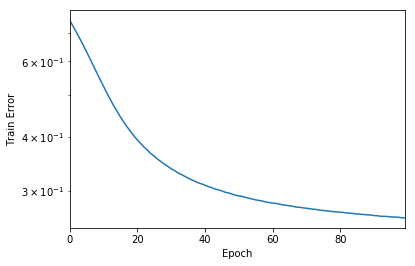

In [39]:
import matplotlib.pyplot as plt

pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [42]:
from sklearn.metrics import mean_absolute_error

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

0.95463576927007399